In [1]:
ON_COLAB = True

if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# torch
!pip install torch
import torch
from torch.nn import Conv2d, MaxPool2d
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import sampler
#!pip install torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
# other
import sys
sys.path.append('drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/')
import params2
import params
#!pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os 
from pathlib import Path
#!pip install pandas
import pandas as pd
#!pip install imageio
import imageio
from csv import writer
from csv import reader
from PIL import Image
!pip install trimesh
import trimesh
!pip install pyrender
import pyrender
if ON_COLAB:
    from tqdm.notebook import tqdm
else:
    #!pip install tqdm
    from tqdm import tqdm
!pip install wandb
import wandb
!wandb login --relogin
# api_key = f2c3bd208d418cf11dcc2c2cbf5e4bc0fc104421

# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
par2 = params2.Parameters()
par = params.Parameters()

print(par.run_id)
print(par2.run_id)

1mvukpct
2t7uzdmb


In [5]:
os.environ["PYOPENGL_PLATFORM"] = "egl" #opengl seems to only work with TPU
!PYOPENGL_PLATFORM=egl python -c "from OpenGL import EGL"
print(os.environ['PYOPENGL_PLATFORM']) 

import OpenGL.GL as gl
print(gl.glGetString(gl.GL_VERSION))

print(gl.glGetString(gl.GL_VENDOR)) 

egl
None
None


In [6]:
mean = np.array([-2.58225823e-01, -2.49824982e-01, -2.15930693e+02, -9.99999954e-01,
 -5.27407286e-06,  8.86791644e-01,  3.72445384e-01,  2.09772325e-03,
 -1.67669566e-02])
std = np.array([4.07212223e+01, 4.08990570e+01, 1.07118527e+02, 1.15640213e-06,
 3.02149915e-04, 1.48045155e-01, 2.30147014e-01, 7.04849566e-01,
 7.09155524e-01])

In [7]:
# DEFINE THE RESNET ARCHITECTURE

# define Resnet building blocks
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel))
        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding=0, bias=False),
                                          nn.BatchNorm2d(outchannel))

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# define Resnet
class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=9):
        super(ResNet, self).__init__()

        self.inchannel = 64
        self.conv1 = nn.Sequential(Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3, bias = False), 
                                  nn.BatchNorm2d(64), 
                                  nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, stride=2, padding=1)
        self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.maxpool2 = nn.MaxPool2d(2, stride=1, padding=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.layer5 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.avgpool = nn.AvgPool2d(4)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        #print('x_shape', x.shape)
        x = self.conv1(x)
        #print('x_shape', x.shape)
        x = self.maxpool(x)
        #print('x_shape', x.shape)
        x = self.layer1(x)
        #print('x_shape', x.shape)
        x = self.maxpool2(x)
        #print('x_shape', x.shape)
        x = self.layer2(x)
        #print('x_shape', x.shape)
        x = self.maxpool2(x)
        #print('x_shape', x.shape)
        x = self.layer3(x)
        #print('x_shape', x.shape)
        x = self.maxpool2(x)
        #print('x_shape', x.shape)
        x = self.layer4(x)
        #print('x_shape', x.shape)
        #x = self.maxpool2(x)
        #print('x_shape', x.shape)
        #x = self.layer4(x)
        #print('x_shape', x.shape)
        x = self.avgpool(x)
        #print('x_shape', x.shape)
        x = x.view(x.size(0), -1)
        #print('x_shape', x.shape)
        x = self.fc(x)
        #print('x_shape', x.shape)
        x[:,3:9] = torch.tanh(x[:,3:9])
        return x

def MyResNet():
    return ResNet(ResidualBlock)

In [8]:
print(par.run_id)
if par.resume:
    run = wandb.init(project="Deep Pose Estimation", 
                        entity="cuccomat",
                        id=par.run_id,
                        resume=True)
else:
    run = wandb.init(project="Deep Pose Estimation", 
            entity="cuccomat",
            config = {
                    "learning_rate": par.learning_rate,
                    "lr_decay": par.decay,
                    "weight_decay": par.weight_decay,
                    "batch_size": par.batch_size,
                    "epochs": par.epochs
                })

1mvukpct


wandb: Currently logged in as: cuccomat. Use `wandb login --relogin` to force relogin


In [9]:
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
        

    def forward(self, x):
        enc1 = self.encoder1(x)
        #print('enc1', enc1.shape)
        enc2 = self.encoder2(self.pool1(enc1))
        #print('enc2', enc2.shape)
        enc3 = self.encoder3(self.pool2(enc2))
        #print('enc3', enc3.shape)
        enc4 = self.encoder4(self.pool3(enc3))
        #print('enc4', enc4.shape)

        bottleneck = self.bottleneck(self.pool4(enc4))
        #print('bottleneck', bottleneck.shape)

        dec4 = self.upconv4(bottleneck)
        #print('dec4', dec4.shape)
        dec4 = torch.cat((dec4, enc4), dim=1)
        #print('dec4', dec4.shape)
        dec4 = self.decoder4(dec4)
        #print('dec4', dec4.shape)
        dec3 = self.upconv3(dec4)
        #print('dec3', dec3.shape)
        dec3 = torch.cat((dec3, enc3), dim=1)
        #print('dec3', dec3.shape)
        dec3 = self.decoder3(dec3)
        #print('dec3', dec3.shape)
        dec2 = self.upconv2(dec3)
        #print('dec2', dec2.shape)
        dec2 = torch.cat((dec2, enc2), dim=1)
        #print('dec2', dec2.shape)
        dec2 = self.decoder2(dec2)
        #print('dec2', dec2.shape)
        dec1 = self.upconv1(dec2)
        #print('dec1', dec1.shape)
        dec1 = torch.cat((dec1, enc1), dim=1)
        #print('dec1', dec1.shape)
        dec1 = self.decoder1(dec1)
        #print('dec1', dec1.shape)
        return self.conv(dec1)

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )


In [10]:
print(par2.run_id)
if par2.resume:
    run = wandb.init(project="Deep Pose Estimation PnP Downsampled", 
                        entity="cuccomat",
                        id=par.run_id,
                        resume=True)
else:
    run = wandb.init(project="Deep Pose Estimation PnP Downsampled", 
            entity="cuccomat",
            config = {
                    "learning_rate": par.learning_rate,
                    "lr_decay": par.decay,
                    "weight_decay": par.weight_decay,
                    "batch_size": par2.batch_size_1,
                    "epochs": par.epochs
                })

2t7uzdmb


Test loss on new datatset,0.00077
learning_rate,1e-05
loss,0.00185
rot_loss [°],0.00051
rot_val_loss [°],0.00047
tra_loss [cm],0.00453
tra_val_loss [cm],0.00818
val_loss,0.00304


In [11]:
mean = torch.from_numpy(mean)
std = torch.from_numpy(std)

In [14]:
import time
from scipy.spatial.transform import Rotation as R
!pip install opencv-python
import cv2

distortion_coeffs = np.zeros((4,1))
im_width, im_height = (256,256)
camK = np.array([[886.81/4,0.0,512.0/4],[0.0,886.81/4,512.0/4],[0.0,0.0,1.0]])
# TEST
#Is it possibile to set an initial value for traslations and rotations?
def test(model_r, model_u, image):
    global mean
    global std
    #print('image_shape', image.shape)
    img = image[None, :]

    first_pose_long = model_r(img.to(device))
    ResNet_time = time.time()
    #print('first_pose', first_pose_long.shape)
    first_pose_long[:,:3] = (first_pose_long[:,:3].cpu() * std[:3]) + mean[:3]
    first_pose = torch.zeros((first_pose_long.shape[0], 6))
    first_pose[:,:3] =  first_pose_long[:,:3]
    #print('predictions_6', predictions_6)

    first_pose[:, 3] = torch.rad2deg(torch.acos(first_pose_long[:, 3])) * torch.sign(first_pose_long[:, 4])
    first_pose[:, 4] = torch.rad2deg(torch.acos(first_pose_long[:, 5])) * torch.sign(first_pose_long[:, 6])
    first_pose[:, 5] = torch.rad2deg(torch.acos(first_pose_long[:, 7])) * torch.sign(first_pose_long[:, 8])

    first_pose = torch.squeeze(first_pose, dim=0) 
    #print('xyz_rpy_p', first_pose.shape)
    #print('xyz_rpy_p', type(first_pose))
    tx_p, ty_p, tz_p, rx_p, ry_p, rz_p = first_pose.cpu().detach().numpy()
    print('xyz_rpy_p', first_pose)

    ty_p = -ty_p
    ry_p = -ry_p 
    rz_p = -rz_p 
    r_p = R.from_euler('xyz',[rx_p, ry_p, rz_p], degrees=True)

    Twc_p = np.eye(4)
    Twc_p[:3,:3] = r_p.as_matrix()
    Twc_p[:3,3] = np.array([tx_p, ty_p, tz_p])
    #print('Twc', Twc)



    camera = pyrender.IntrinsicsCamera(camK[0,0],camK[1,1],
                                        camK[0,2],camK[1,2], zfar = 500.0)

    tm = trimesh.load(par.tm_path) 
    mesh = pyrender.Mesh.from_trimesh(tm)
    scene=pyrender.Scene()
    scene.add(camera,pose=Twc_p)
    scene.add(mesh,pose=np.eye(4))
    r = pyrender.OffscreenRenderer(im_width, im_height)
    color,depth = r.render(scene)
    depth = depth[:,:]
    figure = plt.figure(figsize = (5, 5))
    plt.imshow(depth, alpha = 0.4, cmap = plt.cm.gray_r)
    plt.imshow(np.transpose(image, (1,2,0)), alpha = 0.6, cmap = plt.cm.gray_r)
    plt.axis('off')
    plt.show()
    figure.savefig('FinalPnP.png', bbox_inches='tight', pad_inches = 0)

    Tcw = np.linalg.inv(Twc_p)
    print('Tcw', Tcw)

    #Take into account of the 180° rotation around x
    Tglcv= np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

    Tcw = Tglcv @ Tcw
    print('Tcw', Tcw)

    #print('Rcw', type(Rcw))
    Rcw = Tcw[:3,:3]
    r_new = R.from_matrix(Rcw)
    print('r_new', r_new)

    tvec_cw = (Tcw[:3,3])
    tvec_cw = tvec_cw.astype('float32')
    print('tvec_cw', tvec_cw)
    print('tvec_cw', tvec_cw.shape)
    print('tvec_cw', type(tvec_cw))
    #print('tvec_cw', type(tvec_cw))
    #print('tvec_cw', type(tvec_cw[0]))

    #rvec_cw = r_new.as_euler('xyz', degrees=True)
    rvec_cw = r_new.as_rotvec()
    rvec_cw = rvec_cw.astype('float32')
    print('rvec_cw', rvec_cw)
    print('rvec_cw', rvec_cw.shape)
    print('rvec_cw', type(rvec_cw))
    #print('rvec_cw', type(rvec_cw))
    #print('rvec_cw', type(rvec_cw[0]))
    start_time_2 = time.time()
    obj_coordinates = model_u(img.to(device))
    U_Net_time = time.time()
    obj_coordinates = torch.squeeze(obj_coordinates)
    print('obj_coordinates', obj_coordinates.shape)


   
    
    #print('obj_coordinates', type(obj_coordinates))
    #obj_coordinates = torch.squeeze(obj_coordinates)
    #print('obj_coordinates', obj_coordinates.shape)

    

    

    counter = 0
    for u in range(256):
        for v in range(256):
            if ((torch.abs(obj_coordinates[0][u][v]) + torch.abs(obj_coordinates[1][u][v]) > 45) and (torch.abs(obj_coordinates[0][u][v]) + torch.abs(obj_coordinates[1][u][v]) < 70) and torch.abs(obj_coordinates[2][u][v]) > 0):
                if counter == 0:
                    twoD_pixels = np.array([[v, u]])
                    threeD_points = np.array([[obj_coordinates[0][v][u].cpu().detach().numpy(), obj_coordinates[1][v][u].cpu().detach().numpy(), obj_coordinates[2][v][u].cpu().detach().numpy()]])
                    counter += 1
                else:
                    twoD_pixels = np.vstack([twoD_pixels, [v, u]])
                    threeD_points = np.vstack([threeD_points, [obj_coordinates[0][v][u].cpu().detach().numpy(), obj_coordinates[1][v][u].cpu().detach().numpy(), obj_coordinates[2][v][u].cpu().detach().numpy()]])


    twoD_pixels = twoD_pixels.astype('float32')
    print('twoD_pixels', twoD_pixels.shape)
    print('twoD_pixels', type(twoD_pixels))
    #print('twoD_pixels', type(twoD_pixels[0][0]))
    threeD_points = threeD_points.astype('float32')
    print('threeD_points', threeD_points.shape)
    print('threeD_points', type(threeD_points))
    #print('threeD_points', type(threeD_points[0][0]))


    rvec, tvec = cv2.solvePnPRefineLM(objectPoints=threeD_points, imagePoints=twoD_pixels, cameraMatrix=camK, distCoeffs=distortion_coeffs, rvec=rvec_cw, tvec=tvec_cw) #CV_ITERATIVE

    print('rvec', rvec)
    print('rvec', rvec.shape)
    print('rvec', type(rvec))
    print('tvec', tvec)
    print('tvec', tvec.shape)
    print('tvec', type(tvec))



    r_2 = R.from_rotvec(rvec)
    rot = r_2.as_euler('xyz', degrees=True)
    print('rot', rot)
    print('rot', rot.shape)
    print('rot', type(rot))

    r_3 = R.from_euler('xyz',rot, degrees=True)
    Tcw_2 = np.eye(4)
    Tcw_2[:3,:3] = r_3.as_matrix()
    Tcw_2[:3,3] = tvec
    print('Tcw_2', Tcw_2)

    Tcw_2 = (Tglcv) @ Tcw_2
    print('Tcw_2', Tcw_2)

    Twc_2 = np.linalg.inv(Tcw_2)
    print('Twc_2', Twc_2)

    Rwc_2 = Twc_2[:3,:3]
    r_new_2 = R.from_matrix(Rwc_2)
    tvec_cw_2 = Twc_2[:3,3]
    tvec_cw_2 = tvec_cw_2.astype('float32')
    print('tvec_cw_2', tvec_cw_2)
    rvec_cw_2 = r_new_2.as_euler('xyz', degrees=True)
    rvec_cw_2 = rvec_cw_2.astype('float32')
    print('rvec_cw_2', rvec_cw_2)

    final_pose_cw = np.concatenate((np.squeeze(tvec_cw_2), np.squeeze(rvec_cw_2)), axis=0)
    print('final_pose_cw', final_pose_cw)
    print('final_pose_cw', final_pose_cw.shape)
    print('final_pose_cw', type(final_pose_cw))

    
                 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


cuda


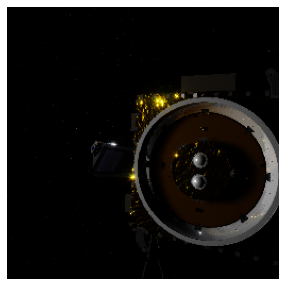

xyz_rpy_p tensor([  26.6245,  -23.5806, -200.4806,  179.2402,   22.3478,  -87.9128],
       grad_fn=<SqueezeBackward1>)


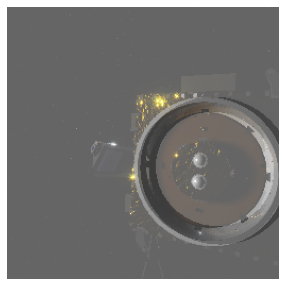

Tcw [[ 3.36843377e-02  9.24279065e-01  3.80228319e-01  5.35365573e+01]
 [ 9.99065107e-01 -4.14549151e-02  1.22638517e-02 -2.31634252e+01]
 [ 2.70975541e-02  3.79459747e-01 -9.24811345e-01 -1.95076104e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Tcw [[ 3.36843377e-02  9.24279065e-01  3.80228319e-01  5.35365573e+01]
 [-9.99065107e-01  4.14549151e-02 -1.22638517e-02  2.31634252e+01]
 [-2.70975541e-02 -3.79459747e-01  9.24811345e-01  1.95076104e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
r_new <scipy.spatial.transform.rotation.Rotation object at 0x7f5dfe0ff6c0>
tvec_cw [ 53.536556  23.163425 195.07611 ]
tvec_cw (3,)
tvec_cw <class 'numpy.ndarray'>
rvec_cw [-0.28839952  0.31991804 -1.5106148 ]
rvec_cw (3,)
rvec_cw <class 'numpy.ndarray'>
obj_coordinates torch.Size([3, 256, 256])
twoD_pixels (4067, 2)
twoD_pixels <class 'numpy.ndarray'>
threeD_points (4067, 3)
threeD_points <class 'numpy.ndarray'>
rvec [-0.10905468 -0.14474773 -1.45051

In [15]:
dtype = torch.float32

device = torch.device('cuda')
print(device)

model_r = MyResNet()
model_r = model_r.to(device=device)
checkpoint_r = torch.load(f"{par.checkpoint_path}/{par.run_id}.tar")
model_r.load_state_dict(checkpoint_r['model_state_dict'])

model_u = UNet()
model_u = model_u.to(device=device)
checkpoint_u = torch.load(f"{par2.checkpoint_path}/{par2.run_id}.tar")
model_u.load_state_dict(checkpoint_u['model_state_dict'])

img_path = 'drive/Othercomputers/Il mio laptop/Deep-Pose-Estimation/baseline/RGB_images_equatoriale/3000-N_.png'
img = imageio.imread(img_path, ignoregamma = True)
rgb_img = img[:,:,:3]
img_tensor = torch.tensor(rgb_img)/255.0
img_tensor = np.transpose(img_tensor, (2, 0, 1))
#print('img_tensor', img_tensor.shape)
img_downsampled = F.interpolate(img_tensor, scale_factor = 0.25)
img_downsampled = np.transpose(img_downsampled, (0, 2, 1))
img_downsampled = F.interpolate(img_downsampled, scale_factor = 0.25)
###img_downsampled = np.transpose(img_downsampled, (0, 2, 1))
img_downsampled = np.transpose(img_downsampled, (2, 1, 0))
image = np.transpose(img_downsampled, (2, 0, 1))
figure = plt.figure(figsize = (5, 5))
plt.imshow(np.transpose(image, (1,2,0)))
plt.axis('off')
plt.show()   
figure.savefig('InitialImage.png', bbox_inches='tight', pad_inches = 0)


test(model_r, model_u, image)